### Import the necessary packages

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
from tracker import tracker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

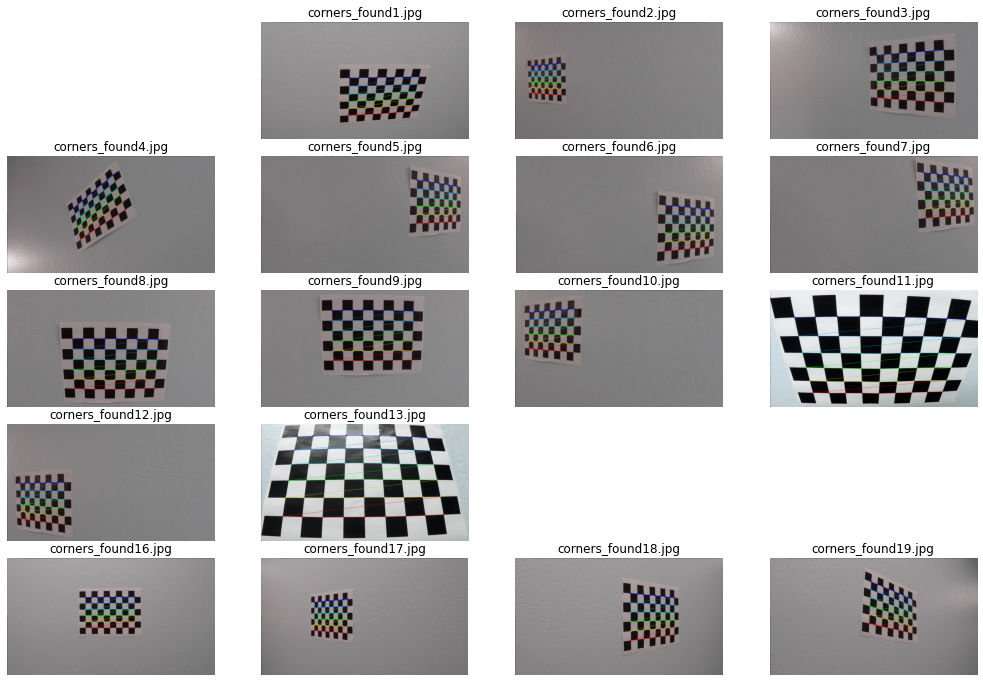

In [2]:
# Calibrate the Camera
# number of inside corners in x & y directions
nx = 9
ny = 6
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(5,4)
# set the spacing between axes.
grid.update(wspace=0.05, hspace=0.15)

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add to object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name,img)
        img_plt = plt.subplot(grid[idx])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        #img_plt.set_aspect('equal')
        plt.imshow(img)
        plt.title(write_name)
        plt.axis('off')
plt.show()
    #plt.axis('off')

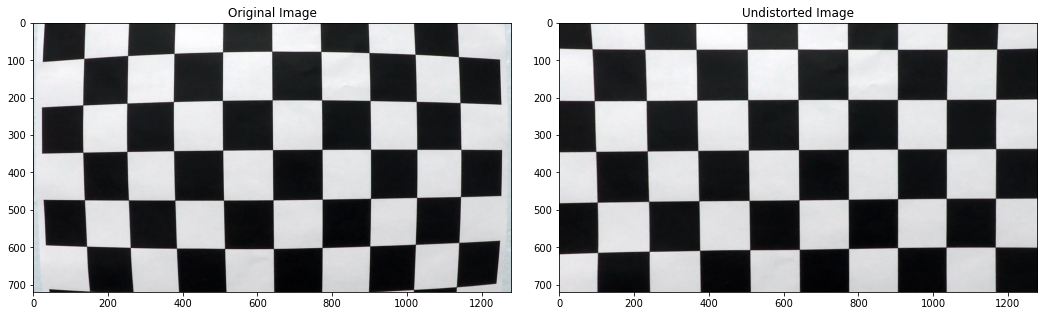

In [3]:
# Take an image, object points, image points, and perform the camera calibration
# Undistort the image after camera calibration
# load image for reference
image = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (image.shape[1],image.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

#Visualizing the before/after distortion on chessboard images
undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

img_plt = plt.subplot(grid[0])
plt.imshow(image)
plt.title('Original Image')

img_plt = plt.subplot(grid[1])
plt.imshow(undist)
plt.title('Undistorted Image')

plt.show()


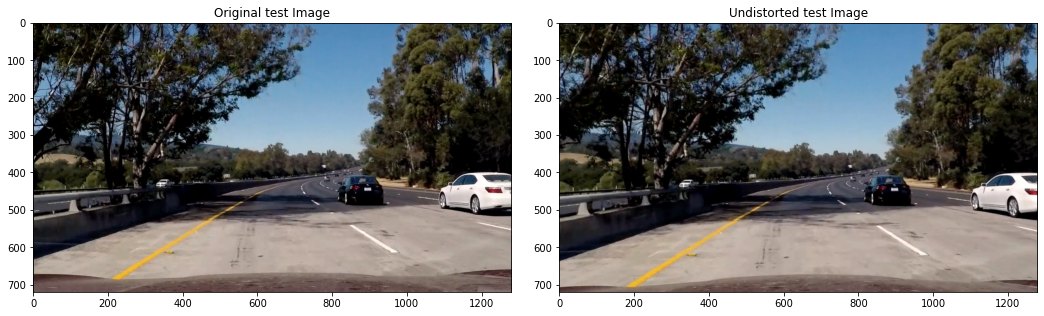

In [4]:
testImg = cv2.imread('./test_images/test5.jpg')
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)

undistTest = cv2.undistort(testImg, mtx, dist, None, mtx)

#Visualizing the before/after distortion on test images
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)

img_plt = plt.subplot(grid[0])
plt.imshow(testImg)
plt.title('Original test Image')

img_plt = plt.subplot(grid[1])
plt.imshow(undistTest)
plt.title('Undistorted test Image')

plt.show()

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    return output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1

    return output

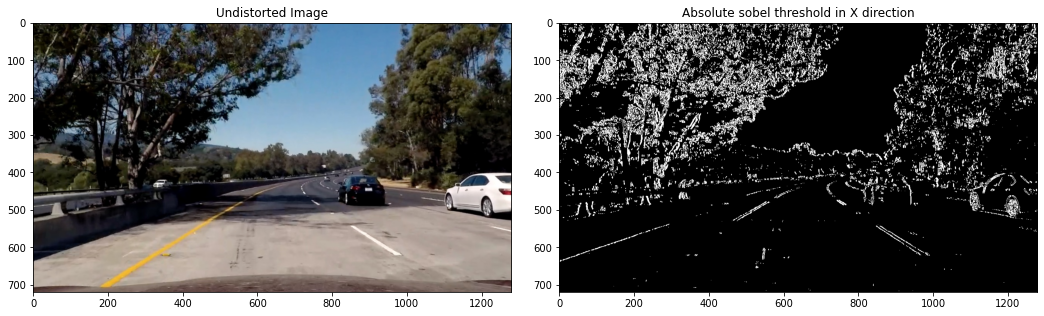

In [6]:
gradx = abs_sobel_thresh(undistTest, orient='x', thresh_min=20, thresh_max=100)

#Visualize the results before/after absolute sobel operator is applied on a test image in x direction to find the
#vertical lines, since the lane lines are close to being vertical
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(gradx, cmap="gray")
plt.title('Absolute sobel threshold in X direction')

plt.show()

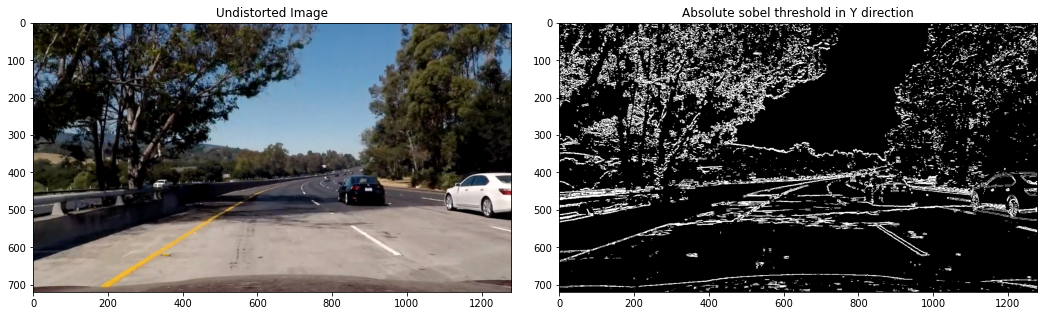

In [7]:
#Apply Sobel operator in Y-direction to experiment with gradient thresholds
grady = abs_sobel_thresh(undistTest, orient='y', thresh_min=20, thresh_max=100)

#Visualize the results before/after sobel operator is applied on a test image in y direction 
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(grady, cmap="gray")
plt.title('Absolute sobel threshold in Y direction')

plt.show()

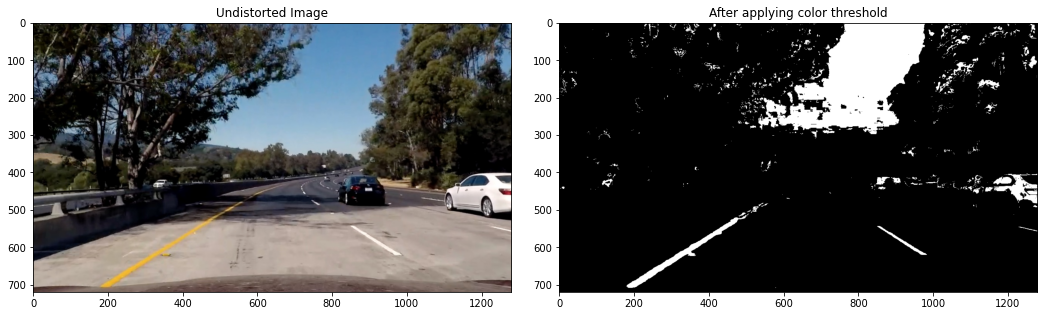

In [8]:
#Experiment with HLS & HSV color spaces along with thresholds
c_binary = color_threshold(undistTest, sthresh=(100,255), vthresh=(50,255))

#Visualize the results before/after HLS/HSV  threshold is applied
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(c_binary, cmap="gray")
plt.title('After applying color threshold')

plt.show()

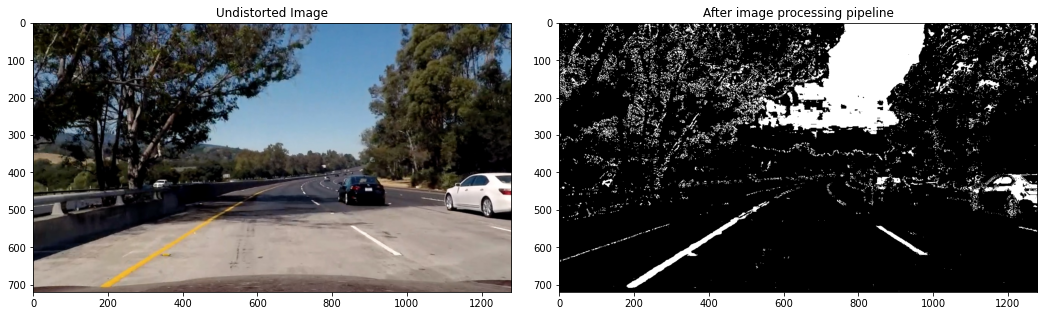

In [9]:
#Combine the binary images using the Sobel thresholds in X/Y directions along with the color threshold to form the final image pipeline
preprocessImage = np.zeros_like(undistTest[:,:,0])
preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

#Visualize the results before/after combining the images from the pipeline
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')
plt.subplot(grid[1])
plt.imshow(preprocessImage, cmap="gray")
plt.title('After image processing pipeline')

plt.show()

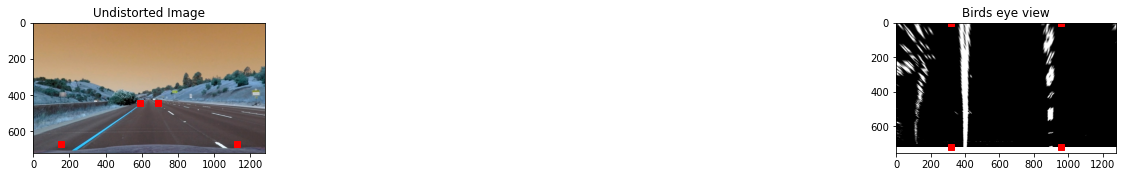

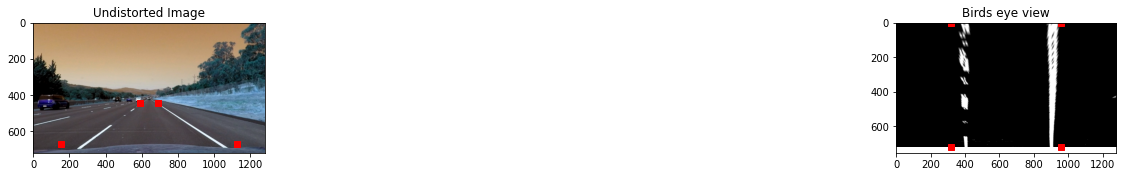

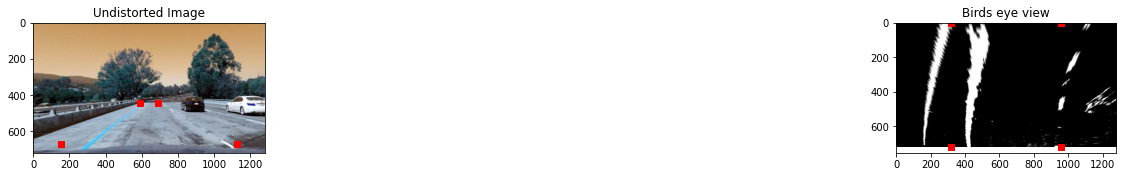

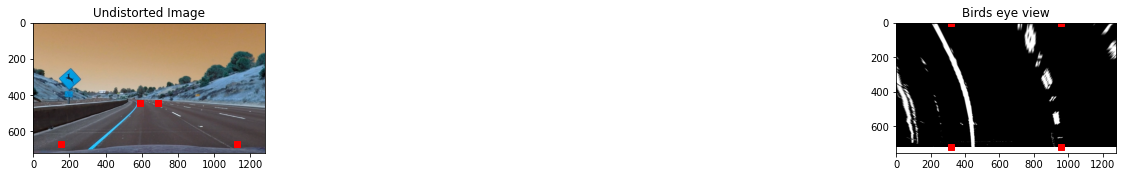

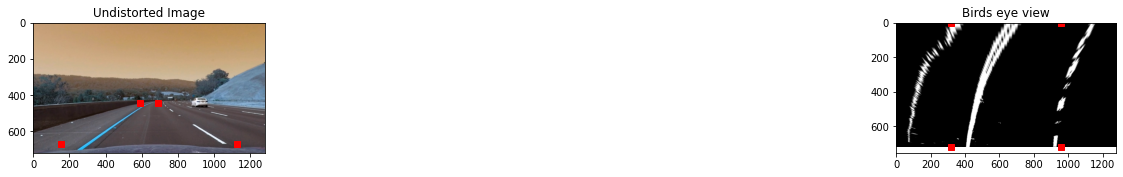

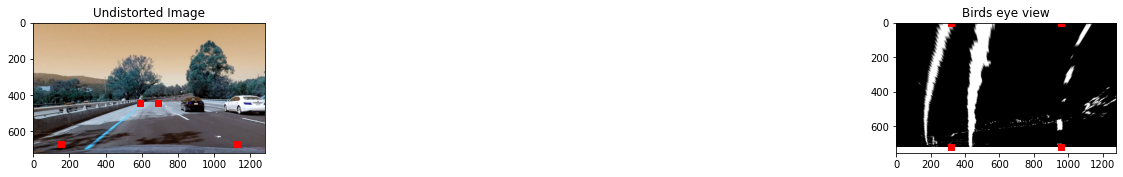

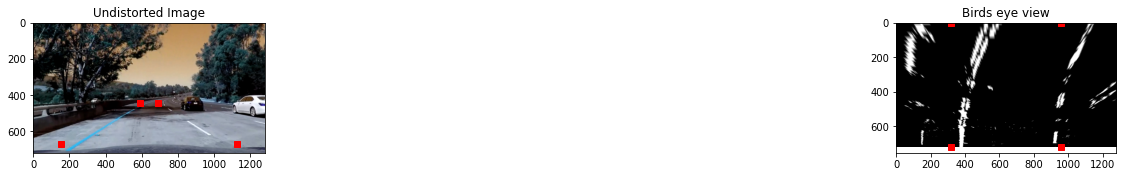

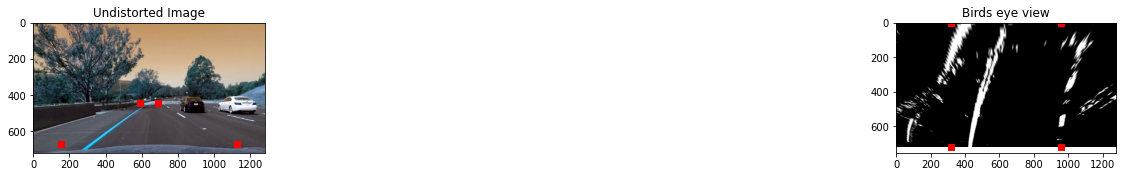

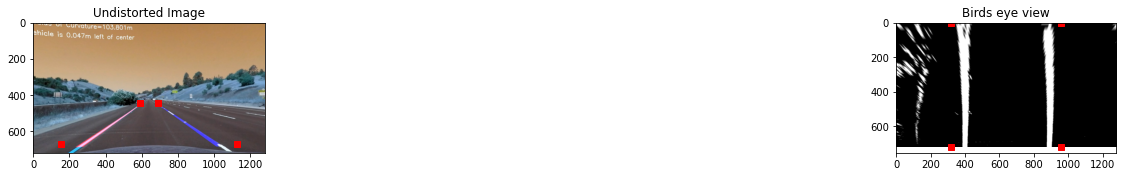

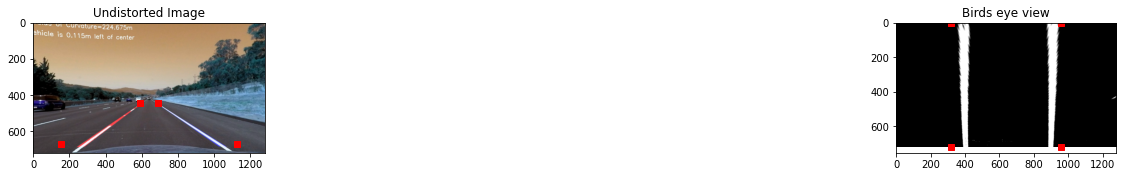

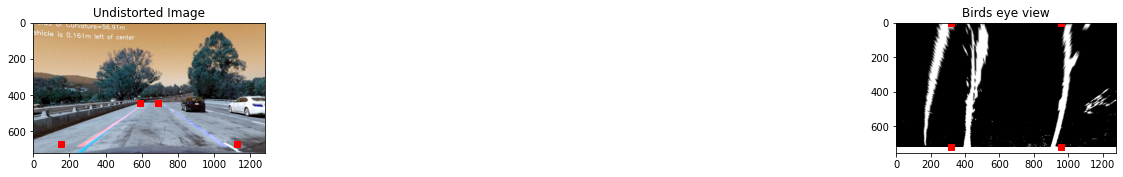

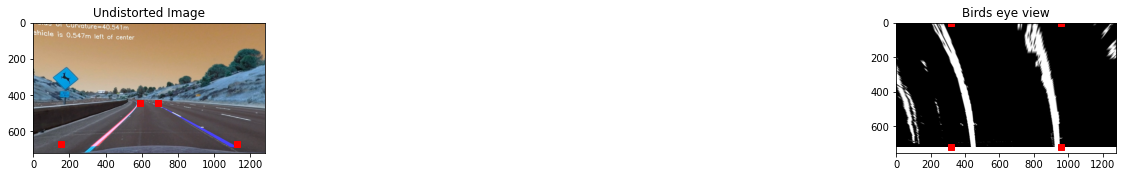

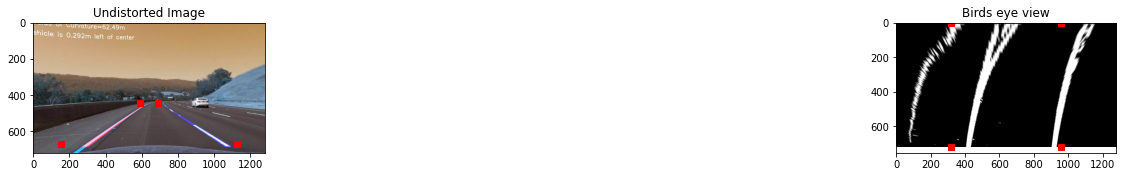

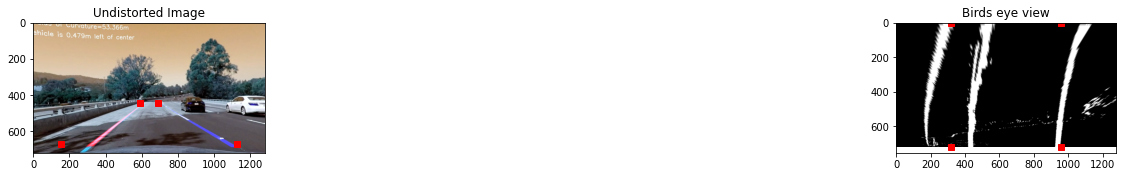

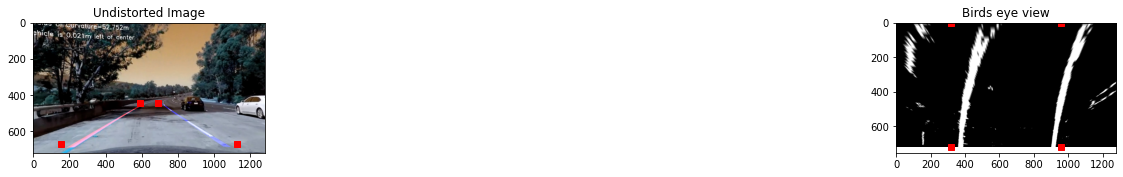

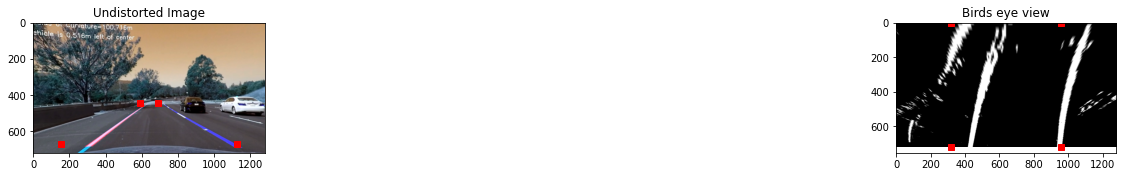

In [10]:
# Read and make a list of test images
images = glob.glob('./test_images/*.jpg')
gidx = 0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])

    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    plt.subplot(grid[gidx])
    plt.imshow(img, cmap="gray")
    for i in range(4):
        plt.plot(src[i][0],src[i][1],'rs')
    plt.title('Undistorted Image')

    plt.subplot(grid[gidx+1])
    plt.imshow(warped, cmap="gray")
    for i in range(4):
        plt.plot(dst[i][0],dst[i][1],'rs')
    plt.title('Birds eye view')

plt.show()


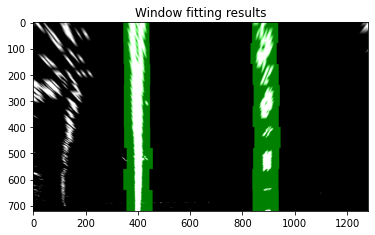

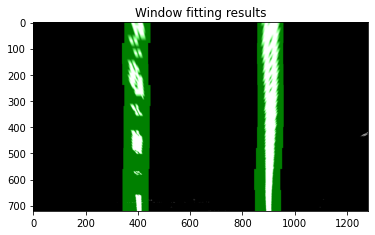

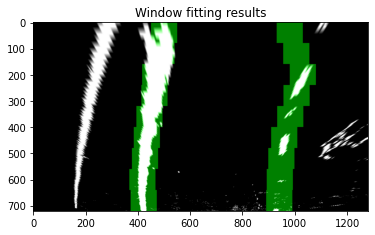

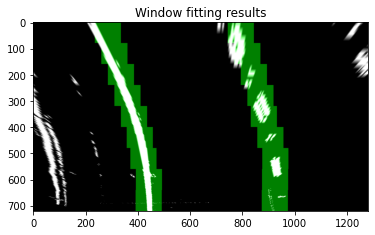

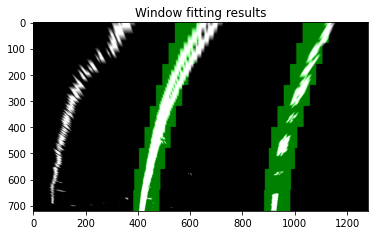

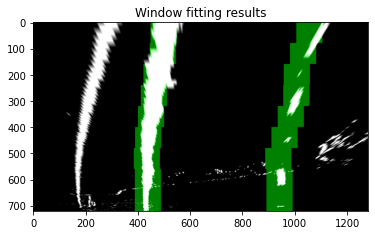

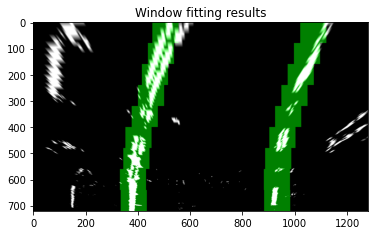

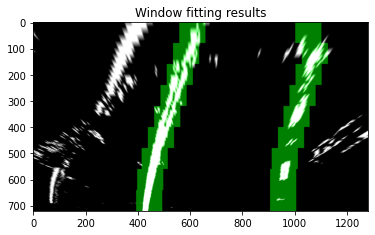

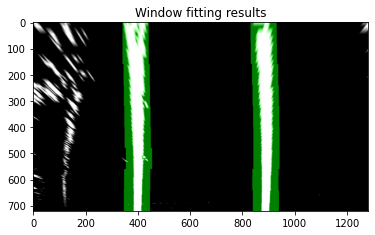

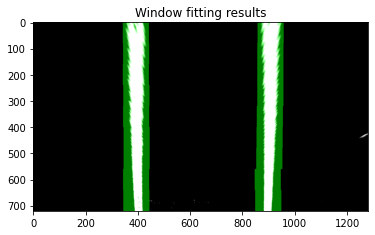

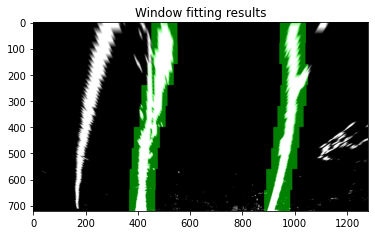

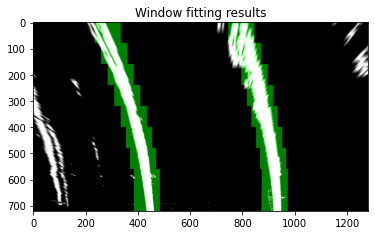

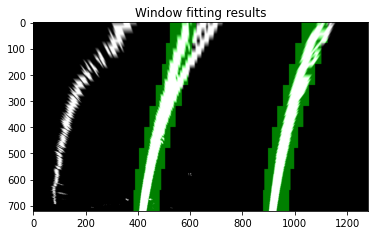

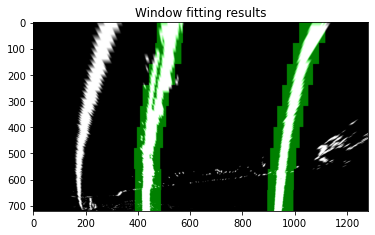

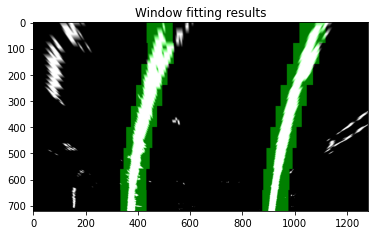

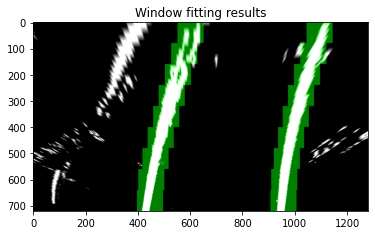

In [11]:
for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
   
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 50
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    #Visualize the results of the window fitting to lane lines
    plt.imshow(result, cmap='gray')
    plt.title('Window fitting results')
    plt.show()

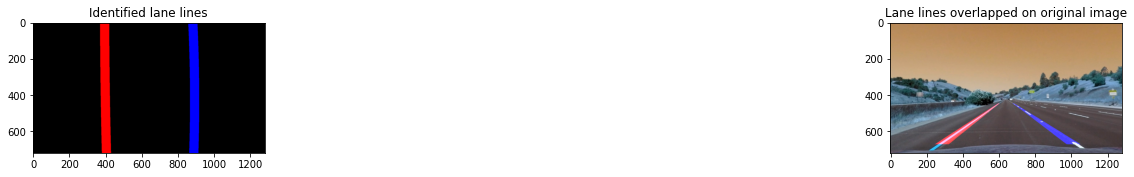

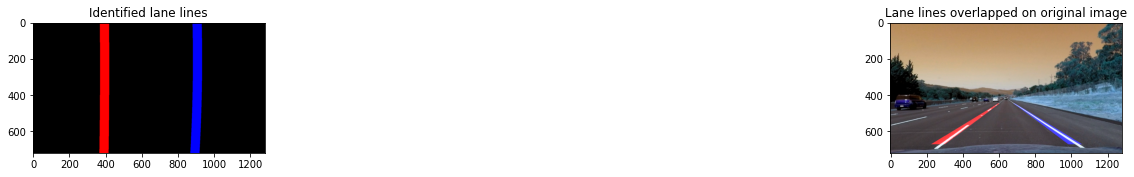

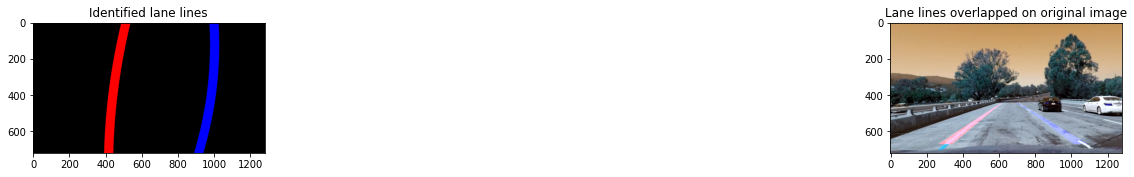

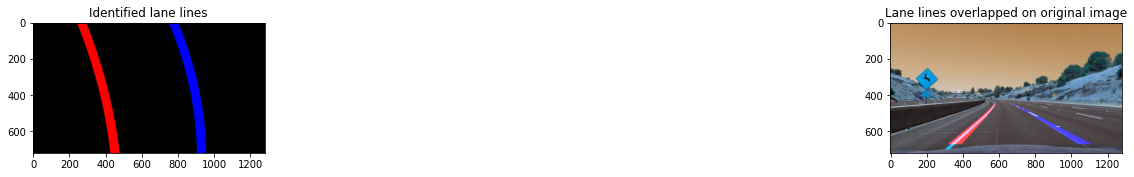

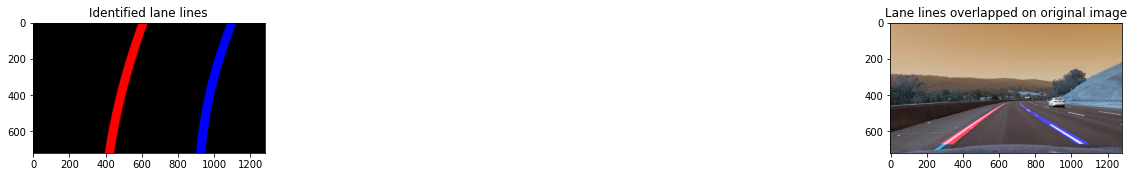

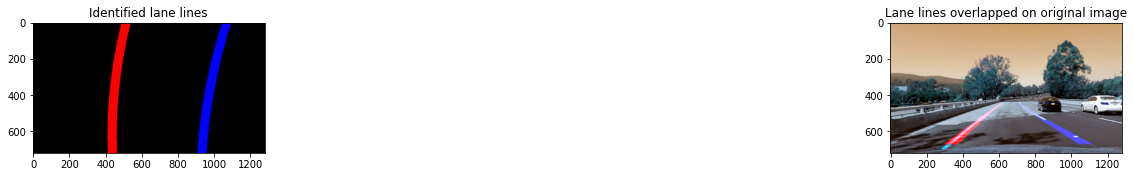

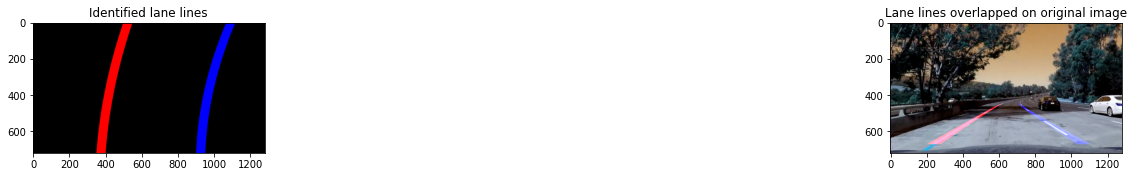

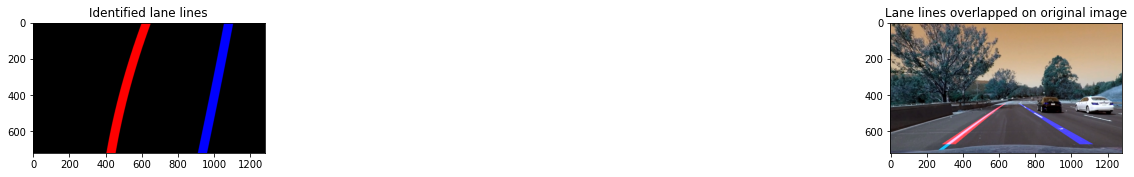

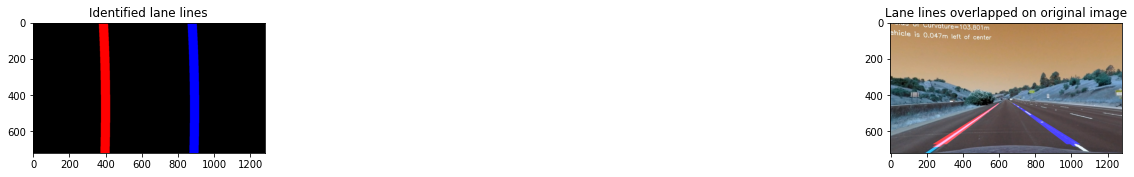

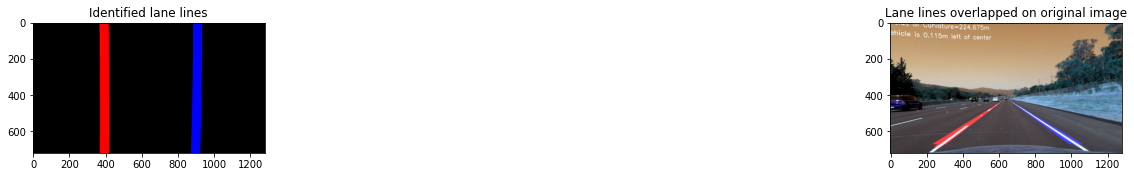

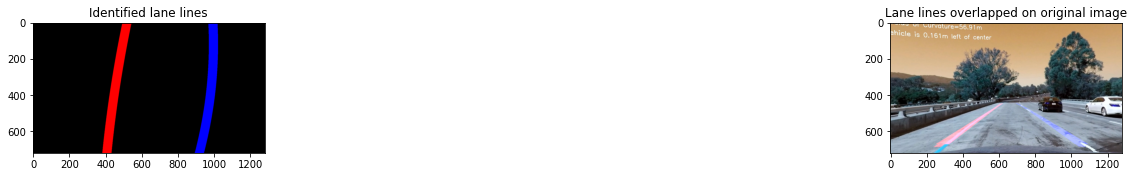

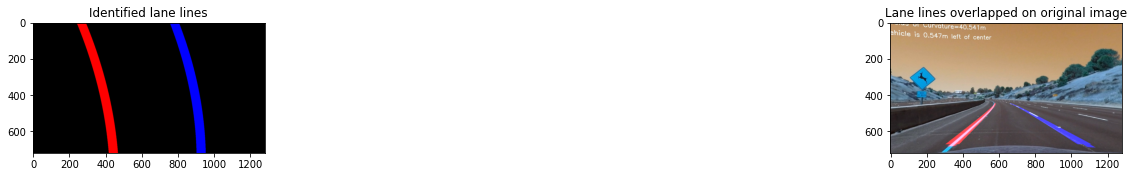

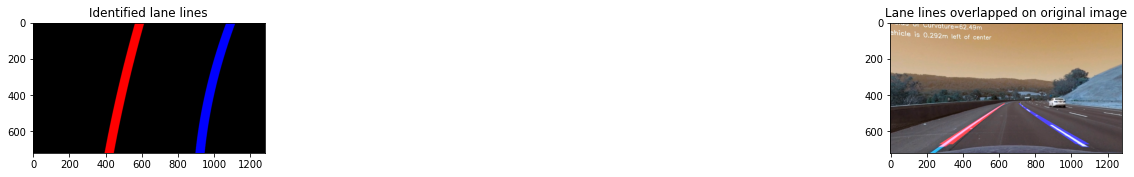

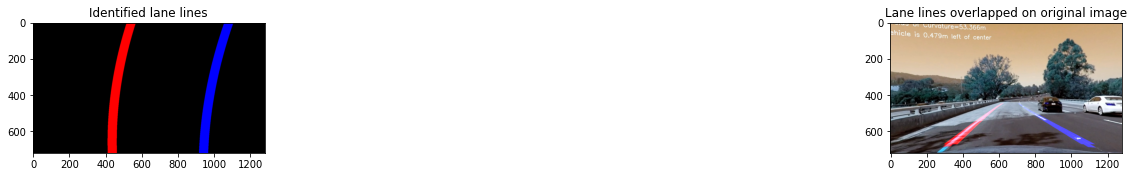

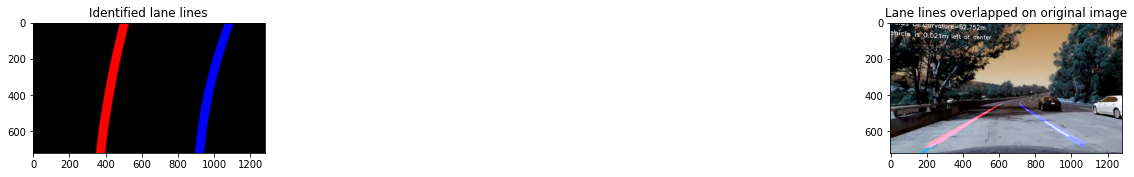

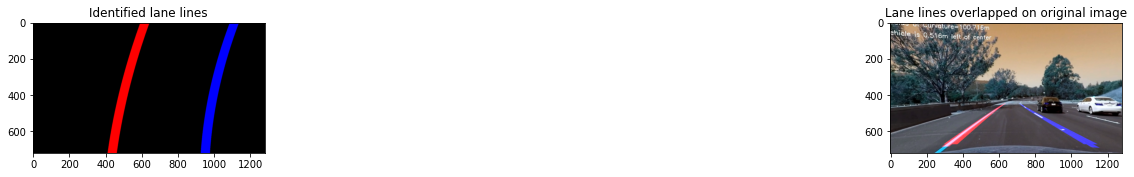

In [12]:
gidx=0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   
    
    #src = np.float32([(532, 496), (756, 496), (288, 664), (1016, 664)])
    #dst = np.float32([(src[2][0], src[2][1] - 200),(src[3][0], src[3][1] - 200),(src[2][0], src[2][1]),(src[3][0], src[3][1])])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 50
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

    #Visualize the results of identified lane lines and overlapping them on to the original undistorted image
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    #img_plt = plt.subplot(grid[0])
    plt.subplot(grid[gidx])
    plt.imshow(road, cmap="gray")
    plt.title('Identified lane lines')

    #img_plt = plt.subplot(grid[1])
    plt.subplot(grid[gidx+1])
    plt.imshow(result, cmap="gray")
    plt.title('Lane lines overlapped on original image')
    
plt.show()

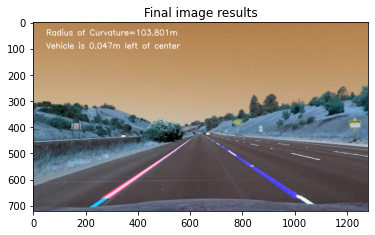

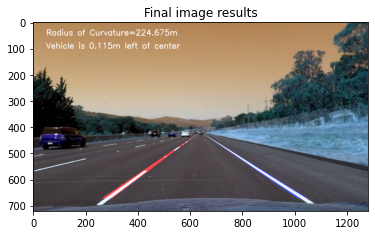

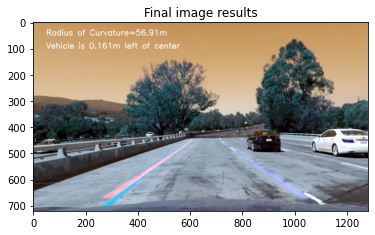

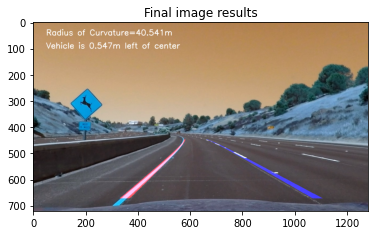

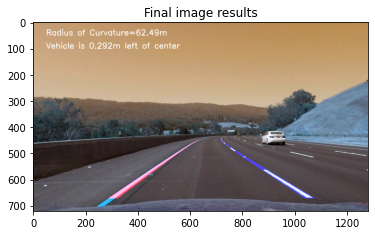

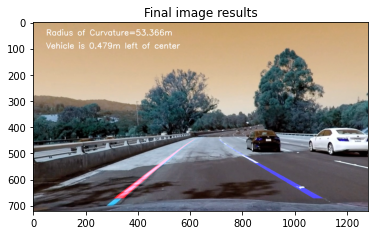

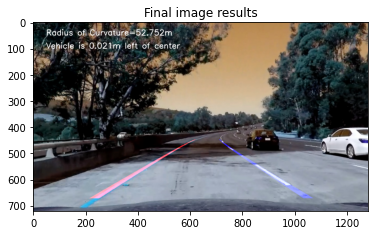

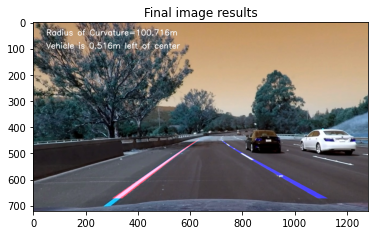

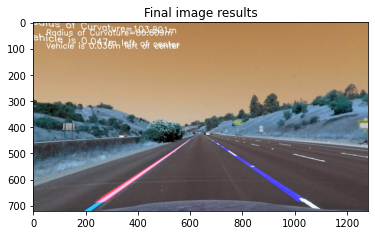

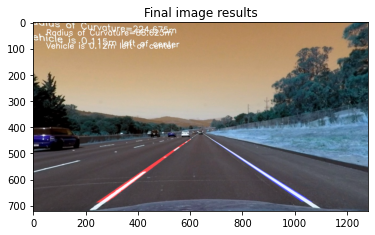

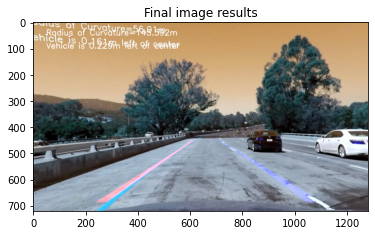

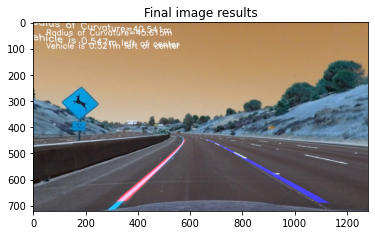

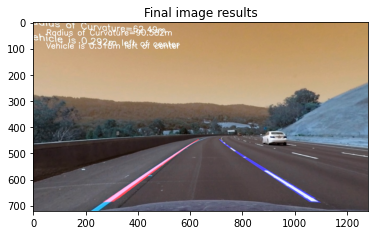

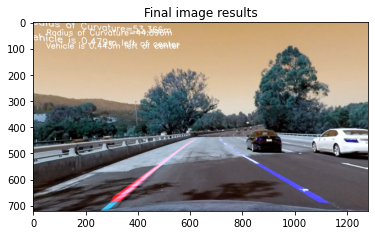

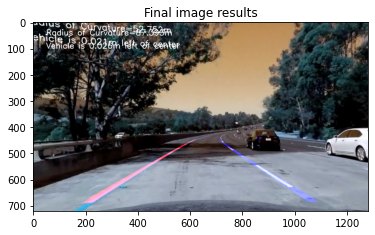

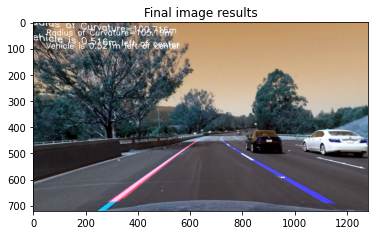

In [13]:
gidx=0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 25
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    plt.imshow(result, cmap='gray')
    plt.title('Final image results')
    plt.show()
    
    write_name='./test_images/tracked'+str(idx)+'.jpg'
    cv2.imwrite(write_name, result)

In [22]:
# Set up the process videos function
def process_image(img):
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    warptrap = np.copy(img)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    binaryImage = np.copy(preprocessImage)
    binaryImage = np.array(cv2.merge((binaryImage,binaryImage,binaryImage)),np.uint8)
    cv2.putText(binaryImage, 'Binary Image',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   
    
    cv2.line(warptrap, (int(src[0][0]), int(src[0][1])), (int(src[1][0]), int(src[1][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[1][0]), int(src[1][1])), (int(src[2][0]), int(src[2][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[2][0]), int(src[2][1])), (int(src[3][0]), int(src[3][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[3][0]), int(src[3][1])), (int(src[0][0]), int(src[0][1])), [255,0,0], 10, cv2.LINE_AA)
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 25
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    windowfit = np.copy(result)
    cv2.putText(windowfit, 'Sliding window results',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    warpage1 = np.copy(warpage)
    cv2.putText(warpage1, 'Bird\'s-eye View',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.line(warpage1, (int(dst[0][0]), int(dst[0][1])), (int(dst[1][0]), int(dst[1][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[1][0]), int(dst[1][1])), (int(dst[2][0]), int(dst[2][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[2][0]), int(dst[2][1])), (int(dst[3][0]), int(dst[3][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[3][0]), int(dst[3][1])), (int(dst[0][0]), int(dst[0][1])), [0,0,255], 10, cv2.LINE_AA)
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    
    #Results screen portion for polynomial fit
    road1 = np.copy(road)
    cv2.putText(road1, 'Polynomial fit',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(25,25),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(25,50), cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2)

    height, width = 1080, 1920
    FinalScreen = np.zeros((height, width, 3), dtype=np.uint8)
    FinalScreen[0:1080,0:1920] = cv2.resize(result, (1920,1080), interpolation=cv2.INTER_AREA)
    FinalScreen[0:360,1280:1920] = cv2.resize(warptrap, (640,360), interpolation=cv2.INTER_AREA)
#     FinalScreen[360:720,1280:1920] = cv2.resize(binaryImage, (640,360), interpolation=cv2.INTER_AREA)
    FinalScreen[360:720,1280:1920] = cv2.resize(warpage1, (640,360), interpolation=cv2.INTER_AREA)
#     FinalScreen[720:1080,0:640] = cv2.resize(windowfit, (640,360), interpolation=cv2.INTER_AREA)
#     FinalScreen[720:1080,640:1280] = cv2.resize(road1, (640,360), interpolation=cv2.INTER_AREA)
    return FinalScreen

t:  56%|█████████████████████████████████████▏                            | 709/1260 [15:25<04:04,  2.26it/s, now=None]

Moviepy - Building video output_tracked.mp4.
Moviepy - Writing video output_tracked.mp4




t:  27%|██████████████████▏                                                 | 67/251 [00:12<00:37,  4.89it/s, now=None]


t:  53%|███████████████████████████████████▌                               | 133/251 [00:26<00:21,  5.51it/s, now=None]


t:  79%|█████████████████████████████████████████████████████              | 199/251 [00:38<00:09,  5.35it/s, now=None]


t:  56%|█████████████████████████████████████▏                            | 709/1260 [16:14<04:04,  2.26it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_tracked.mp4


In [16]:
cap = cv2.VideoCapture('input.mp4')
# cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture("https://192.168.1.7:8080/video")
    
frame_counter = 0
while(True):
    flag, frame = cap.read()
    frame = cv2.resize(frame, (600,400))
    
    frame_counter += 1
    if frame_counter == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        frame_counter = 0
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    cv2.imshow('Input', frame)
    out_frame = process_image(frame)
    out_frame = cv2.resize(out_frame, (600,400))
    cv2.imshow('Output', out_frame)
    if cv2.waitKey(1) == 13:
        break

cap.release()
cv2.destroyAllWindows()